## PTB Diagnostic ECG Database

PTB Diagnostic ECG Database is a collection of 549 high-resolution 15-lead ECGs (12 standard leads together with Frank XYZ leads), including clinical summaries for each record. From one to five ECG records are available for each of the 294 subjects, who include healthy subjects as well as patients with a variety of heart diseases.

#### Data Description

The ECGs in this collection were obtained using a non-commercial, PTB prototype recorder with the following specifications:

16 input channels, (14 for ECGs, 1 for respiration, 1 for line voltage)

Input voltage: ±16 mV, compensated offset voltage up to ± 300 mV
Input resistance: 100 Ω (DC)
Resolution: 16 bit with 0.5 μV/LSB (2000 A/D units per mV)
Bandwidth: 0 - 1 kHz (synchronous sampling of all channels)
Noise voltage: max. 10 μV (pp), respectively 3 μV (RMS) with input short circuit
Online recording of skin resistance
Noise level recording during signal collection


The database contains 549 records from 290 subjects (aged 17 to 87, mean 57.2; 209 men, mean age 55.5, and 81 women, mean age 61.6; ages were not recorded for 1 female and 14 male subjects). Each subject is represented by one to five records. There are no subjects numbered 124, 132, 134, or 161. Each record includes 15 simultaneously measured signals: the conventional 12 leads (i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6) together with the 3 Frank lead ECGs (vx, vy, vz). Each signal is digitized at 1000 samples per second, with 16 bit resolution over a range of ± 16.384 mV. On special request to the contributors of the database, recordings may be available at sampling rates up to 10 KHz.

Within the header (.hea) file of most of these ECG records is a detailed clinical summary, including age, gender, diagnosis, and where applicable, data on medical history, medication and interventions, coronary artery pathology, ventriculography, echocardiography, and hemodynamics. The clinical summary is not available for 22 subjects. 


The diagnostic classes of the remaining 268 subjects are summarized below:

Diagnostic class	Number of subjects
--------------------------------------
Myocardial infarction	148
Cardiomyopathy/Heart failure	18
Bundle branch block		15
Dysrhythmia		14
Myocardial hypertrophy	7
Valvular heart disease	6
Myocarditis	4
Miscellaneous	4
Healthy controls	52

# Environment Creation

The environment is the latest Intel® oneAPI AI Analytics Toolkit intel-aikit-modin environment, which includes data analytics and machine learning workflows such as daal4py, and Intel optimizations for XGboost.

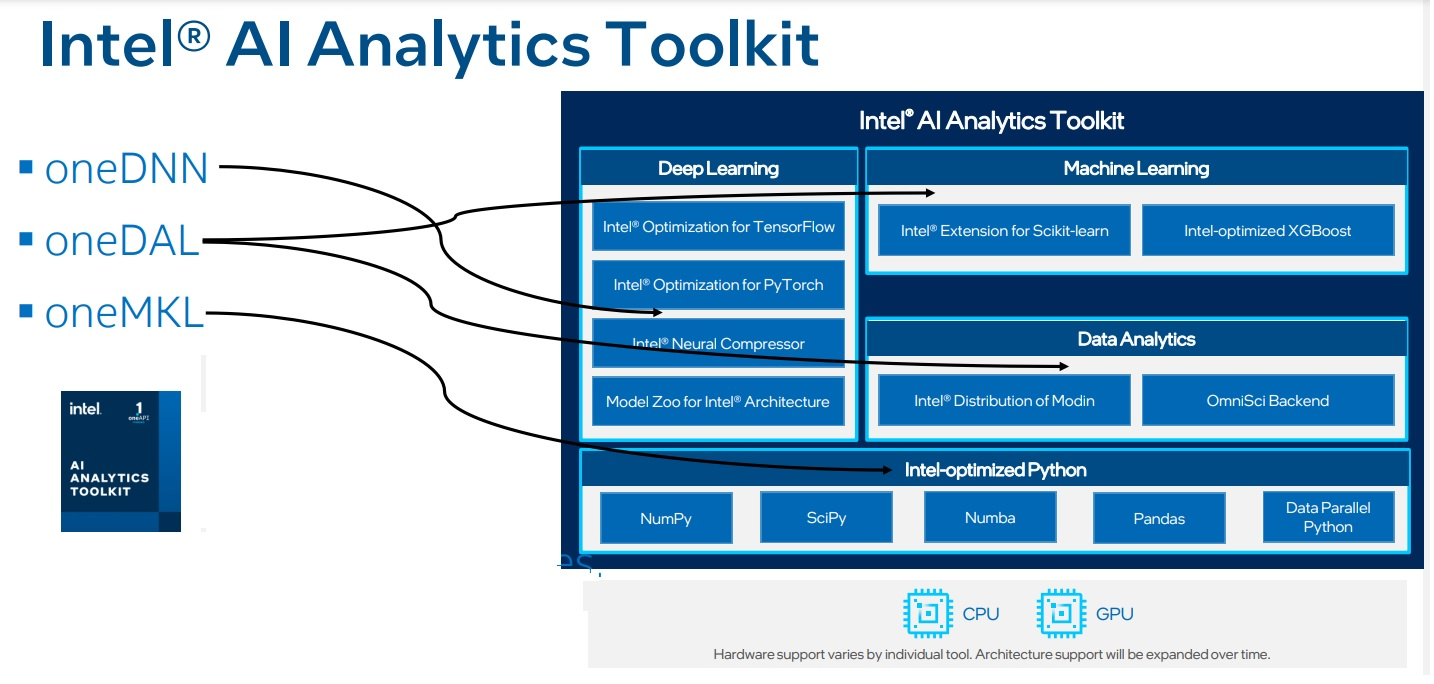

Installing Libraries using PIP python package manager

In [ ]:
!pip install daal4py
!pip install xgboost
!pip install scikit-learn-intelex
!pip install intel-tensorflow
!pip install modin[all]
!pip install dpcpp-cpp-rt
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install Flask
!pip install pandas
!pip install tensorflow
!pip install keras

Importing essential packages from the PIP installed libraries

In [ ]:
import os
import wfdb
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import daal4py as d4p
import xgboost as xgb
import joblib
from flask import Flask, request
import warnings
warnings.filterwarnings('ignore')

# Importing and Organizing Data

In [ ]:
# define the directory path where the PTB dataset is located
data_path = "./ptbdb"

# set the path where the data will be stored
if not os.path.exists(data_path):
    wfdb.dl_database('ptbdb', os.getcwd()+'/ptbdb')

# Preprocessing the ECG Diagnostic data

~ Use bandpass filter to remove noise
~ Normalize signal data
~ Save preprocessed file and plot the data

In [ ]:
# define the directory path where the PTB dataset is located
data_path = "./ptbdb"

for patient_folder in os.listdir(data_path):
    patient_path = os.path.join(data_path, patient_folder)
    
    # Loop through each record file
    for record_file in os.listdir(patient_path):
        if record_file.endswith(".hea"):
            # Read header file to get signal names, number of signals, and sampling frequency
            record_path = os.path.join(patient_path, record_file[:-4])
            record = wfdb.rdheader(record_path)
            signal_names = record.sig_name
            num_signals = record.n_sig
            sampling_freq = record.fs

            # Read signal data from .dat file
            signal_data = wfdb.rdsamp(record_path)[0]
            
            # Define filter coefficients
            b, a = signal.butter(4, [0.01, 0.4], btype='bandpass')

            # Apply bandpass filter to remove noise
            filtered_signal_data = signal.filtfilt(b, a, signal_data, axis=0)

            # Normalize signal data
            normalized_signal_data = (filtered_signal_data - np.mean(filtered_signal_data, axis=0)) / np.std(filtered_signal_data, axis=0)

            # Save preprocessed signal data to .npy file
            if not any(file.endswith(".npy") for file in os.listdir(patient_path)):
                np.save(os.path.join(record_path, "preprocessed.npy"), normalized_signal_data)


            # Convert signal data to CSV format
            if not any(file.endswith(".csv") for file in os.listdir(patient_path)):
                signal_df, fields = wfdb.rdsamp(record_path)
                signal_df = pd.DataFrame(signal_df, columns=fields['sig_name'])
                signal_df['diagnosis'] = record.comments[4].split(": ")[1]
                csv_path = os.path.join(patient_path, record_file[:-4] + ".csv")
                signal_df.to_csv(csv_path, index=False) 

            # Plot the signal data
            wfdb.plot_items(signal=signal_data, title=record_file[:-4])

# ECG data analysis and visualization of a Single Patient 

~ Load the CSV file for the patient
~ Plot the ECG waveform
~ Plot the power spectral density (PSD) of the ECG waveform
~ Calculate the heart rate (HR) by counting the number of QRS complexes and dividing by the total duration of the ECG recording.
~ Calculate the mean and standard deviation of the RR interval (the time between successive R-peaks) to get an estimate of the variability of the heart rate.
~ Calculate the mean and standard deviation of the amplitude of the QRS complex to get an estimate of the strength of the ECG signal.

In [ ]:
# Load CSV file for patient
data_path = "./ptbdb"
patient_folder = "patient001"
record_file = "s0010_re"
csv_path = f"{data_path}/{patient_folder}/{record_file}.csv"
df = pd.read_csv(csv_path)
print(df.keys(), df.shape)

# Plot ECG waveform
plt.figure(figsize=(12, 4))
plt.plot(df["i"])
plt.title("ECG Waveform")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude (mV)")
plt.show()

# Calculate and plot PSD of ECG waveform
f, Pxx = signal.welch(df["i"], fs=360, nperseg=1024)
plt.figure(figsize=(12, 4))
plt.plot(f, Pxx)
plt.title("Power Spectral Density (PSD) of ECG Waveform")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.show()

# Calculate heart rate (HR)
qrs_peaks, _ = signal.find_peaks(df["i"], height=0.5)
duration = len(df) / 360  # total duration of recording in seconds
hr = len(qrs_peaks) / duration
print(f"Heart Rate: {hr:.2f} bpm")
print("The patient has been diagnosed with ",df.loc[0]["diagnosis"])

# Calculate mean and standard deviation of RR interval
rr_intervals = [qrs_peaks[i] - qrs_peaks[i-1] for i in range(1, len(qrs_peaks))]
mean_rr = sum(rr_intervals) / len(rr_intervals) / 360  # convert to seconds
std_rr = (sum((rr - mean_rr*360)**2 for rr in rr_intervals) / (len(rr_intervals) - 1) / 360)**0.5  # convert to seconds
print(f"Mean RR Interval: {mean_rr:.3f} s")
print(f"Standard Deviation of RR Interval: {std_rr:.3f} s")

# Calculate mean and standard deviation of QRS amplitude
mean_qrs_amp = df.loc[qrs_peaks, "i"].mean()
std_qrs_amp = df.loc[qrs_peaks, "i"].std()
print(f"Mean QRS Amplitude: {mean_qrs_amp:.3f} mV")
print(f"Standard Deviation of QRS Amplitude: {std_qrs_amp:.3f} mV")


# Creating Dataframe for PTB Diagnostic ECG Database subjects with diagnosis data of all patients appended to the data for training the Machine Learning models

Steps to combine all the CSV files of patients with the diagnosis information from .hea files added to a column against each patient number specified in the patient folder row-wise:

~ Create an empty DataFrame to store the combined data.
~ Loop through each patient folder and read the diagnosis information from the .hea file.
~ Loop through each CSV file in the patient folder and read the data into a DataFrame.
~ Add a new column to the DataFrame with the diagnosis information.
~ Append the DataFrame to the empty DataFrame created in the initial step.
~ Save the combined data to a CSV file

In [ ]:
# Define data path
data_path = "./ptbdb"

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Number of patients for analysis
num_patients = 294
selected_patients = os.listdir(data_path)[:num_patients]
f_cnt = 0

# Loop through each selected patient folder
for patient_folder in selected_patients:
    patient_path = os.path.join(data_path, patient_folder)
    # Rest of the code for data processing goes here

    f_cnt += 1
    
    print(f_cnt)
    
    # Read the diagnosis information from the .hea file
    diagnosis_files = glob.glob(os.path.join(patient_path, "*.hea"))
    diagnosis = []

    if diagnosis_files:
        for i in range(len(diagnosis_files)):
            diagnosis_file = diagnosis_files[i]
            with open(diagnosis_file, 'r') as f:
                diagnosis.append(f.readline().split()[-1])
    else:
        print(f"No diagnosis file found in {patient_path}")
        continue
    
    # Loop through each CSV file in the patient folder
    for record_file in os.listdir(patient_path):
        if record_file.endswith(".csv"):
            # Read the data into a DataFrame
            csv_path = glob.glob(os.path.join(patient_path, "*.csv"))
            print(csv_path)
            for i in range(len(csv_path)):
                
                csv_data = pd.read_csv(csv_path[i])

                # Add a new column with the diagnosis information
                csv_data['Diagnosis'] = diagnosis[i]

                # Append the DataFrame to the combined data
                combined_data = pd.concat([combined_data, csv_data])

# Define the path for saving the combined data CSV file
combined_data_file = os.path.join(data_path, "combined_data.csv")

# Save the combined data to a CSV file
combined_data.to_csv(combined_data_file, index=False)

# Fitting and Training the models & Graphical visualization of the comparative analysis

~ The data is loaded and split into training and testing sets. 
~ Then, the code trains and evaluates deep neural network model leveraging the Intel optimization for Tensorflow, with hyperparameters tuned based on the PTB ECG diagnostic database being used. Also, training is done for a XGBoost model which was then followed by prediction using the daal4py prediction method for increased performance. Intel optimized XGBoost and daal4py are a part of the oneAPI AI Analytics Toolkit. 
~ Visualize the comparative analysis of the different models.

In [ ]:
# Load ECG data from CSV file
data = pd.read_csv(os.path.join(data_path, 'combined_data.csv'))

print("ECG Data has been loaded")

# Define the mapping of diagnosis labels to numerical values
diagnosis_mapping = {
    "Myocardial infarction": 1,
    "Cardiomyopathy/Heart failure": 2,
    "Bundle branch block": 3,
    "Dysrhythmia": 4,
    "Myocardial hypertrophy": 5,
    "Valvular heart disease": 6,
    "Myocarditis": 7,
    "Miscellaneous": 8,
    "Healthy controls": 9
}

# Convert diagnosis column to numerical values
target = []
for diagnosis in data['diagnosis']:
    if diagnosis in diagnosis_mapping:
        target.append(diagnosis_mapping[diagnosis])
    else:
        target.append(0)
data['diagnosis'] = target

print("Diagnosis info added to data")

# Split data into features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train and Test data obtained")

model_accuracies = {}

print("Starting XGBoost model fitting and training")

# Load in the dataset and organize it as necessary to work with model.

# Datasets creation
xgb_train = xgb.DMatrix(X_train, label=np.array(y_train))
xgb_test = xgb.DMatrix(X_test, label=np.array(y_test))


print("XGBoost train and test DMatrix completed")

# Fitting and training the model using the training dataset.

# training parameters setting
params = {
    'max_bin': 256,
    'scale_pos_weight': 2,
    'lambda_l2': 1,
    'alpha': 0.9,
    'max_depth': 8,
    'num_leaves': 2**8,
    'verbosity': 0,
    'objective': 'multi:softmax',
    'learning_rate': 0.3,
    'num_class': 5,
}

# Training
xgb_model = xgb.train(params, xgb_train, num_boost_round=100)

print("Training of XGB model done")

# Save the trained model as a .pkl file
filename = 'xgb_model.pkl'
joblib.dump(model, filename)

print(".pkl file of trained model saved")

# XGBoost Prediction
# Also make a prediction using XGBoost for accuracy/performance comparison.

# XGBoost prediction (for accuracy comparison)
t0 = time.time()
xgb_prediction = xgb_model.predict(xgb_test)
t1 = time.time()
xgb_errors_count = np.count_nonzero(xgb_prediction - np.ravel(y_test))

xgb_total = t1-t0


print("XGB prediction completed")

# daal4py Prediction
# make a prediction using daal4py for increased performance.

# Conversion to daal4py
daal_model = d4p.get_gbt_model_from_xgboost(xgb_model)

print("DAAL model conversion of XGBoost model completed")

# Save the trained model as a .pkl file
filename = 'daal_model.pkl'
joblib.dump(model, filename)

print(".pkl file of trained model saved")

# daal4py prediction
daal_predict_algo = d4p.gbt_classification_prediction(
    nClasses=params["num_class"],
    resultsToEvaluate="computeClassLabels",
    fptype='float'
)
t0 = time.time()
daal_prediction = daal_predict_algo.compute(X_test, daal_model)
t1 = time.time()
daal_errors_count = np.count_nonzero(daal_prediction.prediction -  y_test)

d4p_total = t1-t0
assert np.absolute(xgb_errors_count - daal_errors_count) == 0
y_test = np.ravel(y_test)
daal_prediction = np.ravel(daal_prediction.prediction)

print("DAAL model prediction completed")

# Visualizations
# Performance
left = [1,2]
pred_times = [xgb_total, d4p_total]
tick_label = ['XGBoost Prediction', 'daal4py Prediction']
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Prediction Method'); plt.ylabel('time,s'); plt.title('Prediction time,s')
plt.show()
print("speedup:",xgb_total/d4p_total)

# Accuracy
left = [1,2]
xgb_acc = 1 - xgb_errors_count / xgb_prediction.shape[0]
model_accuracies['XGBoost'] = xgb_acc
d4p_acc = 1 - daal_errors_count / daal_prediction.shape[0]
model_accuracies['DAAL'] = d4p_acc
pred_acc = [xgb_acc, d4p_acc]
tick_label = ['XGBoost Prediction', 'daal4py Prediction']
plt.bar(left, pred_acc, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Prediction Method'); plt.ylabel('accuracy, %'); plt.title('Prediction Accuracy, %')
plt.show()
print("Accuracy Difference",xgb_acc-d4p_acc)

print("[MODEL_COMPLETED_SUCCESFULLY]")

print("Starting Deep Learning model training")

# Train Deep Learning model
deep_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deep_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

print("Fitting and Training deep learn model completed")

# Save the trained model as a .pkl file
filename = 'deep_model.pkl'
joblib.dump(model, filename)

print("Saved the trained Deep Learning model as .pkl file")

# Evaluate Deep Learning model
_, accuracy_deep = deep_model.evaluate(X_test, y_test)
model_accuracies['Deep Learning'] = accuracy_deep
print(f'Deep Learning accuracy: {accuracy_deep:.4f}')

print("[MODEL_COMPLETED_SUCCESFULLY]")

# Plot model accuracies
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.title('Comparative Analysis of ECG Classification Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

# Print the accuracy of patient diagnosis comparison
best_model = max(model_accuracies, key=model_accuracies.get)
print(f"Best Model: {best_model}")
print(f"Accuracy: {model_accuracies[best_model]:.4f}")